In [8]:
# Install Kaggle (if not present) and import libraries
!pip install -q kaggle

# Standard imports
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

print("GPU available:", tf.test.is_gpu_available())


TensorFlow version: 2.19.0
GPU available: True


In [4]:
from google.colab import files
files.upload( )   # for kaggle.json upload


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"mahfuzaakter023","key":"4209c1979581e769c2ec00016759f5fc"}'}

In [9]:
#kaggle Api setup
!mkdir -p ~/.kaggle   #  for kaggle creat folder
!cp kaggle.json ~/.kaggle/  #for kaggle.json file upload in kaggle
!chmod 600 ~/.kaggle/kaggle.json #for file permission setup
!ls -la ~/.kaggle


total 16
drwxr-xr-x 2 root root 4096 Sep 17 00:11 .
drwx------ 1 root root 4096 Sep 17 00:11 ..
-rw------- 1 root root   71 Sep 17 00:30 kaggle.json


In [10]:
#for dataset download
!kaggle datasets download -d emmarex/plantdisease

# Unzip into folder 'plant_disease'
!unzip -q plantdisease.zip -d plant_disease
!ls -la plant_disease | sed -n '1,120p'

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
total 16
drwxr-xr-x  4 root root 4096 Sep 17 00:32 .
drwxr-xr-x  1 root root 4096 Sep 17 00:32 ..
drwxr-xr-x  3 root root 4096 Sep 17 00:32 plantvillage
drwxr-xr-x 17 root root 4096 Sep 17 00:32 PlantVillage


In [11]:
# Prepare binary dataset: Healthy vs Diseased
data_dir = "plant_disease/PlantVillage"
base_dir = "dataset_binary"

for split in ["train","val","test"]:
    for cls in ["Healthy","Diseased"]:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Move/copy images into binary folders
for cls in sorted(os.listdir(data_dir)):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    label = "Healthy" if "healthy" in cls.lower() else "Diseased"
    imgs = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if len(imgs) == 0:
        continue
    train, test = train_test_split(imgs, test_size=0.2, random_state=42)
    val, test = train_test_split(test, test_size=0.5, random_state=42)
    for subset, subset_dir in zip([train, val, test], [os.path.join(base_dir,'train',label), os.path.join(base_dir,'val',label), os.path.join(base_dir,'test',label)]):
        for img in subset:
            try:
                shutil.copy(img, subset_dir)
            except Exception as e:
                print("Could not copy", img, "=>", e)

# Quick counts
for split in ["train","val","test"]:
    print("\nCounts in", split)
    for cls in ["Healthy","Diseased"]:
        p = os.path.join(base_dir, split, cls)
        n = len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"  {cls}: {n}")


Counts in train
  Healthy: 2575
  Diseased: 13929

Counts in val
  Healthy: 322
  Diseased: 1742

Counts in test
  Healthy: 324
  Diseased: 1746


In [12]:
# ImageDataGenerators (augmentation for train)
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(os.path.join(base_dir,'train'), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
val_gen = val_test_datagen.flow_from_directory(os.path.join(base_dir,'val'), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_gen = val_test_datagen.flow_from_directory(os.path.join(base_dir,'test'), target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)

Found 16504 images belonging to 2 classes.
Found 2064 images belonging to 2 classes.
Found 2070 images belonging to 2 classes.


In [13]:
# Build and train a simple CNN baseline
def build_simple_cnn(input_shape=(224,224,3)):
    model = models.Sequential([
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D(2),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(128,(3,3),activation='relu'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_simple_cnn()
cnn_model.summary()

# Train (change epochs as needed)
cnn_history = cnn_model.fit(train_gen, validation_data=val_gen, epochs=6)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,244,929 (84.86 MB)

 Trainable params: 22,244,929 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 211s 394ms/step - accuracy: 0.8506 - loss: 0.3883 - val_accuracy: 0.8004 - val_loss: 0.3925
Epoch 2/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 199s 385ms/step - accuracy: 0.9148 - loss: 0.2057 - val_accuracy: 0.6667 - val_loss: 1.8178
Epoch 3/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 198s 384ms/step - accuracy: 0.9585 - loss: 0.1153 - val_accuracy: 0.7839 - val_loss: 1.1195
Epoch 4/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 216s 411ms/step - accuracy: 0.9751 - loss: 0.0726 - val_accuracy: 0.8595 - val_loss: 0.6059
Epoch 5/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 197s 381ms/step - accuracy: 0.9772 - loss: 0.0665 - val_accuracy: 0.8387 - val_loss: 0.7184
Epoch 6/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 198s 384ms/step - accuracy: 0.9864 - loss: 0.0442 - val_accuracy: 0.7975 - val_loss: 1.5492


In [14]:
# Transfer Learning with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers
def build_mobilenet_transfer(input_shape=(224,224,3)):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=base.input, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet_transfer()
mobilenet_model.summary()

mobilenet_history = mobilenet_model.fit(train_gen, validation_data=val_gen, epochs=6)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 231s 416ms/step - accuracy: 0.9283 - loss: 0.1850 - val_accuracy: 0.9767 - val_loss: 0.0646
Epoch 2/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 194s 376ms/step - accuracy: 0.9625 - loss: 0.0963 - val_accuracy: 0.9656 - val_loss: 0.0949
Epoch 3/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 191s 370ms/step - accuracy: 0.9718 - loss: 0.0760 - val_accuracy: 0.9830 - val_loss: 0.0522
Epoch 4/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 191s 370ms/step - accuracy: 0.9725 - loss: 0.0707 - val_accuracy: 0.9797 - val_loss: 0.0654
Epoch 5/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 193s 374ms/step - accuracy: 0.9769 - loss: 0.0629 - val_accuracy: 0.9821 - val_loss: 0.0515
Epoch 6/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 190s 369ms/step - accuracy: 0.9763 - loss: 0.0652 - val_accuracy: 0.9840 - val_loss: 0.0498


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.86      1746
           1       0.42      0.98      0.59       324

    accuracy                           0.79      2070
   macro avg       0.71      0.87      0.73      2070
weighted avg       0.91      0.79      0.82      2070

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step
MobileNetV2 Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1746
           1       0.96      0.92      0.94       324

    accuracy                           0.98      2070
   macro avg       0.97      0.96      0.96      2070
weighted avg       0.98      0.98      0.98      2070



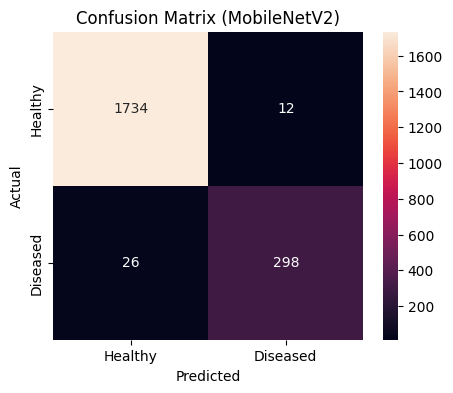

         Model  Accuracy  Precision    Recall        F1
0          CNN  0.789372   0.424933  0.978395  0.592523
1  MobileNetV2  0.981643   0.961290  0.919753  0.940063


In [15]:
# Evaluate on test set: reports and confusion matrix
y_true = test_gen.classes
# CNN predictions
y_prob_cnn = cnn_model.predict(test_gen)
y_pred_cnn = (y_prob_cnn > 0.5).astype('int32')
print("CNN Classification Report:\n", classification_report(y_true, y_pred_cnn))

# MobileNet predictions
y_prob_mnet = mobilenet_model.predict(test_gen)
y_pred_mnet = (y_prob_mnet > 0.5).astype('int32')
print("MobileNetV2 Classification Report:\n", classification_report(y_true, y_pred_mnet))

# Confusion matrix for MobileNet
cm = confusion_matrix(y_true, y_pred_mnet)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Healthy","Diseased"], yticklabels=["Healthy","Diseased"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix (MobileNetV2)")
plt.show()

# Summary table
results = {
    "Model": ["CNN","MobileNetV2"],
    "Accuracy": [accuracy_score(y_true, y_pred_cnn), accuracy_score(y_true, y_pred_mnet)],
    "Precision": [precision_score(y_true, y_pred_cnn), precision_score(y_true, y_pred_mnet)],
    "Recall": [recall_score(y_true, y_pred_cnn), recall_score(y_true, y_pred_mnet)],
    "F1": [f1_score(y_true, y_pred_cnn), f1_score(y_true, y_pred_mnet)]
}
df_results = pd.DataFrame(results)
print(df_results)

Using last conv layer: Conv_1


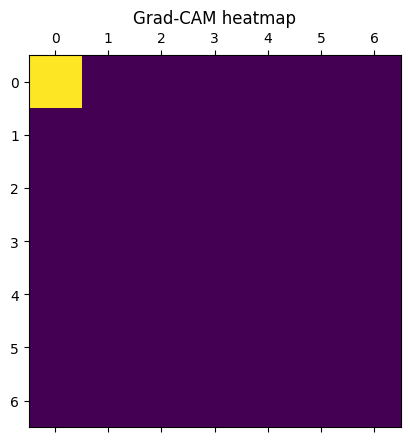

In [20]:
# Grad-CAM example for MobileNetV2 (choose a conv layer name if needed)
import tensorflow as tf
import cv2, numpy as np
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap

# Use a test image
if len(test_gen.filepaths) > 0:
    img_path = test_gen.filepaths[0]
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    # Last conv layer name in MobileNetV2 often 'Conv_1' but may vary
    layer_name = None
    for layer in mobilenet_model.layers[::-1]:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer_name = layer.name
            break
    print("Using last conv layer:", layer_name)
    heatmap = get_gradcam_heatmap(mobilenet_model, img_array, layer_name)
    plt.matshow(heatmap)
    plt.title("Grad-CAM heatmap")
    plt.show()
else:
    print("No test images found.")

In [22]:
# Save trained models to Drive (optional)
os.makedirs('/content/drive/MyDrive/plant_models', exist_ok=True)
cnn_model.save('/content/drive/MyDrive/plant_models/cnn_model.keras')
mobilenet_model.save('/content/drive/MyDrive/plant_models/mobilenet_model.keras')
print("Models saved to /content/drive/MyDrive/plant_models/")

Models saved to /content/drive/MyDrive/plant_models/
